# Setup

In [2]:
# Data manipulation
import pandas as pd
# Decision tree
from sklearn.datasets import load_iris
from sklearn import tree
# Render tree
import graphviz
from sklearn.externals.six import StringIO  
import pydot 
# Plotting
import matplotlib.pyplot as plt
# Validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from plot_cm import plot_confusion_matrix
# Other
from collections import Counter

## Preliminary look at the data

In [3]:
raw_data = pd.read_excel('Training_Set_8_14_18.xlsx') # Labeled dataset
raw_data.head()

,Classification,Gene,WT (t1) Avg,WT (t1) Var,WT (t2) Avg,WT (t2) Var,MT (t1) Avg,MT (t1) Var,MT (t2) Avg,MT (t2) Var,Z score,Early_FC,Mid_FC
0,Highly Expressed,YALI0F30789g,4.065780,0.058687,3.738464,0.341579,5.080346,0.163244,5.674979,0.297808,1.125603,1.712035,2.565667
1,Highly Expressed,YALI0C21802g,7.628213,0.016660,7.190041,0.034189,8.644947,0.258089,8.954191,0.006210,1.174746,1.639471,3.393857
2,Highly Expressed,YALI0C20361g,2.790715,0.448068,0.651478,7.472600,3.711594,0.029249,3.979949,0.032411,1.179500,1.431241,1.663715
3,Highly Expressed,YALI0F12331g,6.685987,0.154599,6.862580,0.301944,7.413071,0.215857,8.603608,0.267156,1.217112,1.136262,2.381286
4,Highly Expressed,YALI0C00671g,4.407611,0.074736,4.283998,0.165925,5.082540,0.169677,5.818683,0.011725,1.283683,1.125271,2.636523


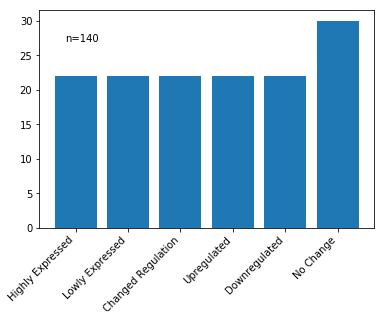

In [4]:
z = Counter(raw_data.Classification)
plt.bar(z.keys(),z.values())
plt.xticks(rotation=45, ha='right');
plt.text(-0.2,27,'n={}'.format(raw_data.Classification.size));

The dataset consists of 140 points with very well distributed classes. 

## Prepare data for analysis

In [5]:
# Map class to integers:
classes = raw_data.Classification.unique()
class_map = dict(zip(classes,[i for i in range(len(classes))]))
# Create data and target:
target = raw_data.Classification.map(class_map)
features_tp =['WT (t1) Avg', 'WT (t2) Avg','MT (t1) Avg','MT (t2) Avg']
features_f = ['Z score', 'Early_FC', 'Mid_FC']
data_tp = raw_data[features_tp] 
data_f = raw_data[features_f]

# Tree1: Using Z and FC as features

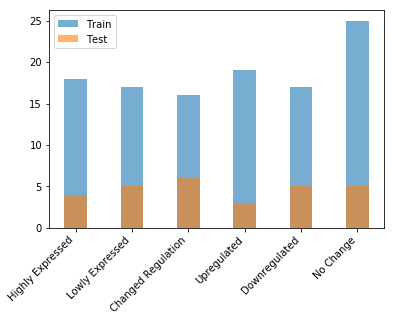

In [6]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(data_f, target, test_size=0.2, random_state=50)
bins = []
for i in range(0,len(classes)):
    bins.append(i-0.2)
    bins.append(i+0.2)
plt.hist(y_train, bins=bins, label='Train', alpha=0.6)
plt.hist(y_test, bins=bins, label='Test', alpha=0.6)
plt.legend()
plt.xticks(range(0,len(classes)),classes,rotation=45, ha='right');

In [7]:
# Training
clf = tree.DecisionTreeClassifier(random_state=100) # Make results reproducible
clf = clf.fit(X_train, y_train)

# Render tree
dot_data = tree.export_graphviz(clf, out_file='temp.dot', 
                         feature_names=features_f,  
                         class_names=classes,  
                         filled=True, rounded=True)  
#graphviz.render(dot_data, format='svg',filepath='temp')
graph = graphviz.Source(dot_data)  
#graph.render('test.pdf')
#graph 
# graphiz does not work on my linux comp, so:
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data, feature_names=features_f,  
                         class_names=classes,  
                         filled=True, rounded=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_svg('tree1.svg') 

![](tree1.svg "Example")

Accuracy:100.0%


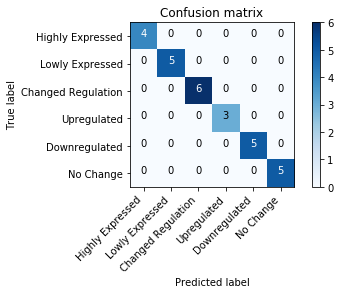

In [8]:
# Validation
y_pred = clf.predict(X_test)
print('Accuracy:{}%'.format(accuracy_score(y_test, y_pred)*100))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

# Tree2: Using Average tpm

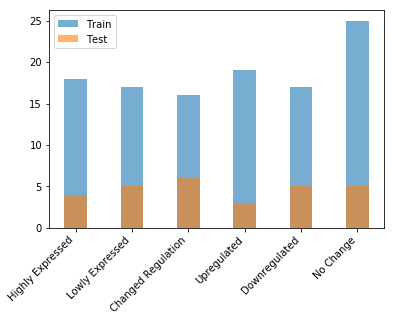

In [9]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(data_tp, target, test_size=0.2, random_state=50)
bins = []
for i in range(0,len(classes)):
    bins.append(i-0.2)
    bins.append(i+0.2)
plt.hist(y_train, bins=bins, label='Train', alpha=0.6)
plt.hist(y_test, bins=bins, label='Test', alpha=0.6)
plt.legend()
plt.xticks(range(0,len(classes)),classes,rotation=45, ha='right');

In [10]:
# Training
clf = tree.DecisionTreeClassifier(random_state=100) # Make results reproducible
clf = clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf, out_file='temp2', 
                         feature_names=features_tp,  
                         class_names=classes,  
                         filled=True, rounded=True)  
graph = graphviz.Source(dot_data)  
#graph
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data, feature_names=features_tp,  
                         class_names=classes,  
                         filled=True, rounded=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_svg('tree2.svg') 

![](tree2.svg "Example")

Accuracy:60.71428571428571%


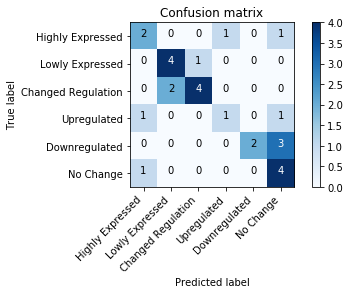

In [11]:
# Validation
y_pred = clf.predict(X_test)
print('Accuracy:{}%'.format(accuracy_score(y_test, y_pred)*100))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

# Conclusions

- Tree 1 is much simpler and accurate than Tree 2, indicating that Z and FC are good variables to characterize the target patterns. 
- Tree 1 achieves perfect classification accuracy with very simple divisitions, however this tree migth not be as intuitive as the manually designed one.
- Accuracy can be improved by optimizing hyperparameters, but it is not required at this point since tree 1 achieves perfect classification. 
- Tree 2 can be improved by adding standard deviations and optimizing hyperparameters. 
- There are alternative trees that may explain the data, that is why the random number generator is fixed to produce reproducible results. 

# Test first try with semi-manually classified genes


In [28]:
full_data = pd.read_excel('Data_Set_8_14_18.xlsx') # Labeled dataset
full_data.head()

,Classification,Gene,WT (t1) Avg,WT (t1) Var,WT (t2) Avg,WT (t2) Var,MT (t1) Avg,MT (t1) Var,MT (t2) Avg,MT (t2) Var,Z score,Early_FC,Mid_FC
0,No_Change,YALI0A00132g,9.457800,0.020907,9.553724,0.344613,10.201013,0.001549,9.377357,0.162136,-1.286261,1.463927,-0.248583
1,Upregulated,YALI0A00154g,12.287076,0.086591,8.807630,2.935695,8.930943,7.397624,11.690833,0.417750,2.623888,-1.682769,2.077140
2,Upregulated,YALI0A00176g,0.897152,0.465443,-1.237630,2.821682,0.227909,2.970987,2.502347,0.506467,2.338618,-0.486720,2.703271
3,Changed_Regulation,YALI0A00212g,4.073944,0.106011,2.948922,0.023460,1.263225,0.386316,3.334175,0.906364,3.290436,-4.063299,0.455637
4,No_Change,YALI0A00264g,8.228712,0.016221,8.219064,0.096013,8.166010,0.005167,7.801997,0.057882,-0.612306,-0.123447,-0.729402


Accuracy:29.852744310575634%


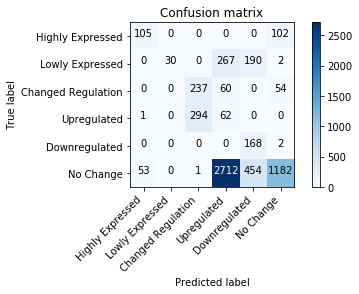

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data_f, target, test_size=0.2, random_state=50)
clf = tree.DecisionTreeClassifier(random_state=100) # Make results reproducible
clf = clf.fit(X_train, y_train)

new_class_map = {k.replace(" ", "_"):v for k,v in class_map.items()}

y_true = full_data.Classification.map(new_class_map)
X = full_data[features_f]

y_pred = clf.predict(X)
print('Accuracy:{}%'.format(accuracy_score(y_true, y_pred)*100))
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

# Create new tree with semi-manually classified genes

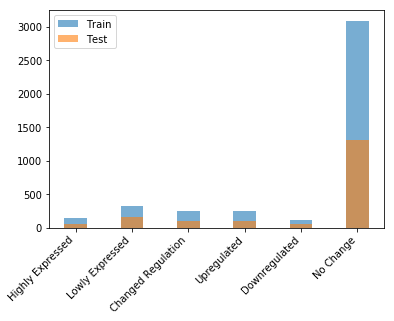

In [32]:
X = full_data[features_f]
y = full_data.Classification.map(new_class_map)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)
bins = []
for i in range(0,len(classes)):
    bins.append(i-0.2)
    bins.append(i+0.2)
plt.hist(y_train, bins=bins, label='Train', alpha=0.6)
plt.hist(y_test, bins=bins, label='Test', alpha=0.6)
plt.legend()
plt.xticks(range(0,len(classes)),classes,rotation=45, ha='right');

In [36]:
# Training
clf = tree.DecisionTreeClassifier(random_state=100) # Make results reproducible
clf = clf.fit(X_train, y_train)

# Render tree
dot_data = tree.export_graphviz(clf, out_file='temp.dot', 
                         feature_names=features_f,  
                         class_names=classes,  
                         filled=True, rounded=True)  
#graphviz.render(dot_data, format='svg',filepath='temp')
graph = graphviz.Source(dot_data)  
#graph.render('test.pdf')
#graph 
# graphiz does not work on my linux comp, so:
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data, feature_names=features_f,  
                         class_names=classes,  
                         filled=True, rounded=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph[0].write_svg('tree3.svg') 

![](tree3.svg "Example")

Accuracy:99.49804796430564%


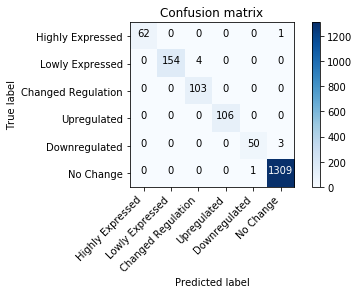

In [34]:
# Validation
y_pred = clf.predict(X_test)
print('Accuracy:{}%'.format(accuracy_score(y_test, y_pred)*100))
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)